<a href="https://colab.research.google.com/github/RajArPatra/MIDAS-task-2/blob/main/MIDAS__Task2__Initial__experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Download

In [ ]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip trainPart1.zip
!wget https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.ziphttps://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip
!unzip mnistTask3.zip

Streaming output truncated to the last 5000 lines.
 extracting: mnistTask/3/image_021488.jpg  
 extracting: mnistTask/3/image_047540.jpg  
 extracting: mnistTask/3/image_050475.jpg  
 extracting: mnistTask/3/image_024391.jpg  
 extracting: mnistTask/3/image_020193.jpg  
 extracting: mnistTask/3/image_004447.jpg  
 extracting: mnistTask/3/image_051601.jpg  
 extracting: mnistTask/3/image_009900.jpg  
 extracting: mnistTask/3/image_020916.jpg  
 extracting: mnistTask/3/image_025962.jpg  
 extracting: mnistTask/3/image_054889.jpg  
 extracting: mnistTask/3/image_012369.jpg  
 extracting: mnistTask/3/image_025528.jpg  
 extracting: mnistTask/3/image_035609.jpg  
 extracting: mnistTask/3/image_037469.jpg  
 extracting: mnistTask/3/image_057560.jpg  
 extracting: mnistTask/3/image_000119.jpg  
 extracting: mnistTask/3/image_020120.jpg  
 extracting: mnistTask/3/image_044129.jpg  
 extracting: mnistTask/3/image_027779.jpg  
 extracting: mnistTask/3/image_058235.jpg  
 extracting: mnistTask/3/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
import torchvision
import os
import numpy as np
from skimage import io,transform as ts
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torch.autograd import Variable
import distutils
from distutils import dir_util
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

GPU selection

In [ ]:
if torch.cuda.is_available():
  device='cuda'
else :
   device='cpu'
device

'cuda'

Data Augmentation

In [ ]:
from albumentations.pytorch import ToTensor
import albumentations as A

seq_s = A.Compose(
    [   A.Resize(28,28),
      
     
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 1
        ),
        
        A.Normalize(
            mean=[0.9418, 0.9418, 0.9418],
            std=[0.2333, 0.2333, 0.2333]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)
    


seq_l= A.Compose(
    [   A.Resize(224,224),
      
     
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 1
        ),
        
        A.Normalize(
            mean=[0.9418, 0.9418, 0.9418],
            std=[0.2333, 0.2333, 0.2333]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)


# DATASET AND DATALOADER

In [ ]:
import imageio
import glob

class Custom_dataset(Dataset):
    def __init__(self,root='/content/merged_data',img_type='png',mnist=False,transforms=None):
      org_lst=os.listdir(root)
      cnt=0
      self.map={}
      self.root=root
      self.transforms=transforms
      self.lst=[]
      self.flag=False
      if root[-1]=='n':
           
        if mnist!=True:
          
          self.lst=glob.glob(root+'/**/*.'+img_type)
          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              self.map.update({i:cnt})
              cnt+=1 
        else:

          self.lst=glob.glob(root+'/**/*.'+img_type)
          lst1=[]
          for i in self.lst:
            #print(int(i.split('/')[-1].split['-'][0][-3:]))
            if int(i.split('/')[-1].split('-')[0][-3:])<11:
              lst1.append(i)
          self.lst=lst1    

          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              if int(i[-3:])<11:
               self.map.update({i:int(i[-3:])-1})
              cnt+=1
      elif root[-1]=='k':
       self.flag=True
       self.lst=glob.glob(root+'/**/*.'+img_type)
       for i in org_lst:
          if i not in self.map: 
            self.map.update({i:int(i)})
            cnt+=1 
      
      


    def __getitem__(self, idx):
      path=self.lst[idx]

      #print(img_p)
      #label=self.map[path.split('/')[-1].split('-')[0]]
      label=self.map[path.split('/')[-2]]
      
      im=imageio.imread(path)
      if self.flag:
        im=np.expand_dims(im, axis=2)
      im_tensor=im
      if self.transforms is not None:
         im_tensor=self.transforms(image=im)['image']
      

      return im_tensor, torch.tensor(label).long() 
      
    def __len__(self):
      #print(len(self.data))
      return len(self.lst)

In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=False,transforms=seq_l)


batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


2480


# TRAINING UTILS

SAVE CHECKPOINT

In [ ]:
def save_checkpoint(model, save_folder, name, epoch, opt, time1,best_model=False):

    if best_model:
        save_path = "{}/{}/best_model.th".format(
            save_folder, name)
    else:
        save_path = "{}/{}/epoch_{}.th".format(save_folder,
                                               name, epoch)

    if not os.path.exists(save_folder + "/" + name):
        os.makedirs(save_folder + "/" + name)

    print("SAVE MODEL to", save_path)


    param_dict = {
        'epoch': epoch,
        'avg_time':time1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict()}
        

    torch.save(param_dict, save_path)
    #writer.close()
    distutils.dir_util.copy_tree('/content/runs','/'.join(save_path.split('/')[:-1])+'/runs')

LOAD CHECKPOINT

In [ ]:
def load_checkpoint(model, save_folder, model_name,epoch,opt,device ,best_model=False):
      if best_model:
        load_path = "{}/model_{}/best_model.th".format(save_folder, model_name)
      else:
        load_path = "{}/{}/epoch_{}.th".format(save_folder,
                                                model_name, epoch)

      checkpoint = torch.load(load_path,map_location=device)

      epoch = checkpoint['epoch']
      time1=checkpoint['avg_time']
      
      model =model # code for model init
      model.load_state_dict(checkpoint['model_state_dict'])
      model=model.to(device)

      opt =opt #code for opt init
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      #opt.param_groups[0]['lr'] = checkpoint['optimizer_params']['lr']
      distutils.dir_util.copy_tree('/'.join(load_path.split('/')[:-1])+'/runs','/content/runs')
      return model, opt, epoch, time1 


WEIGHT INITIALISATION

In [ ]:
from torch.nn import init
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

ACCURACY FUNCTION

In [ ]:
def accuracy_fn(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(1/ batch_size))
    return res

Average Meter

refernce-https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py

In [ ]:
class Meter(object):
    '''Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    '''

    def reset(self):
        '''Resets the meter to default settings.'''
        pass

    def add(self, value):
        '''Log a new value to the meter
        Args:
            value: Next restult to include.
        '''
        pass

    def value(self):
        '''Get the value of the meter in the current state.'''
        pass



import math

import numpy as np


class AverageValueMeter(Meter):
    def __init__(self,std_sh=False):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0
        self.std_sh=std_sh
    def add(self, value, n=1):
        self.val = value
        self.sum += value * n
        if n <= 0:
            raise ValueError("Cannot use a non-positive weight for the running stat.")
        elif self.n == 0:
            self.mean = 0.0 + value  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + n * (value - self.mean_old) / float(self.n + n)
            self.m_s += n * (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n + n - 1.0))
        self.var = self.std ** 2

        self.n += n

    def value(self):
      if self.std_sh:
        return self.mean,self.std
      else:  
        return self.mean
    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan






class SumMeter(Meter):
    def __init__(self):
        super(SumMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.val = 0.0
        

Time calculation

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Convergence Calculation

In [ ]:
import sys
class Convergence(object):
   def __init__(self):
     self.cn_loss=sys.maxsize
     self.cnt=1
     self.meter=AverageValueMeter(True)
     self.meter.add(self.cn_loss)
     self.time=0
     self.epoch=0
   def calc(self,cn_loss,time,epoch):
     if cn_loss>=self.cn_loss:
       self.meter.add(cn_loss)
       self.cnt+=1
      
     else:
       self.meter.reset()
       self.meter.add(cn_loss)
       self.time=time
       self.epoch=epoch
       self.cnt=1
       self.cn_loss=cn_loss

# Train

Training function

In [ ]:
def train(model,train_loader,criterion,optimizer,scheduler,meters,epoch,pr_br,ch=3):
    model.train()
    meters['train_loss'].reset()

    for batch_idx, (data,label) in enumerate(train_loader):
        if ch==1:
          data = data.expand(-1, 3, -1, -1)
        data = data.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        output= model(data)
        loss = criterion(output,label)
        loss.backward()
        meters['train_loss'].add(loss.item())
        optimizer.step()
        writer.add_scalar("Train_Loss/iter", meters['train_loss'].value(),epoch*len(train_loader)+batch_idx )
        if batch_idx %pr_br == 0:        
            print(' Epoch: {} Iter: {} Average train loss: {:.4f}'.format(
                epoch,batch_idx, meters['train_loss'].value()))
    writer.add_scalar("Train_Loss/epoch", meters['train_loss'].value(),epoch)
   # scheduler.step()

Evaluation function

In [ ]:
def mod_eval(model,test_loader,criterion,meters,epoch,pr_br,ch=3):
    model.eval()
    meters['val_loss'].reset()
    meters['val_a1'].reset()
    meters['val_a3'].reset()
    meters['val_a5'].reset()
    for batch_idx, (data,label) in enumerate(test_loader):
        if ch==1:
          data = data.expand(-1, 3, -1, -1)
        data = data.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        output= model(data)
        loss = criterion(output,label)
        meters['val_loss'].add(loss.item())
        r=accuracy_fn(output.data,label.data,(1,3,5))
        meters['val_a1'].add(r[0].item())
        meters['val_a3'].add(r[1].item())
        meters['val_a5'].add(r[2].item())
        writer.add_scalar("Val_Loss/iter", meters['val_loss'].value(),epoch*len(test_loader)+batch_idx )
        writer.add_scalar("accuracy_1/iter", meters['val_a1'].value(), epoch*len(test_loader)+batch_idx)
        writer.add_scalar("accuracy_3/iter", meters['val_a3'].value(),epoch*len(test_loader)+batch_idx)
        writer.add_scalar("accuracy_5/iter", meters['val_a5'].value(), epoch*len(test_loader)+batch_idx)
      
        if batch_idx % pr_br == 0:        
            print(' Epoch: {} Iter: {} Average val loss: {:.4f} Acc1: {:.2f} Acc3: {:.2f} Acc5: {:.2f}'.format(
                epoch,batch_idx, meters['val_loss'].value(),meters['val_a1'].value(),meters['val_a3'].value(),meters['val_a5'].value()))
    writer.add_scalar("Val_Loss/epoch", meters['val_loss'].value(),epoch )
    writer.add_scalar("accuracy_1/epoch", meters['val_a1'].value(), epoch)
    writer.flush()

Main

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
def run(model,criterion,optimizer,scheduler,load_dir,load_model,load_epch=0,N_EPOCHS=20,save_fq=5,ch=3):
  lst_epch=0
  cnt=1
 
  writer = SummaryWriter()
  for epoch in range(lst_epch,lst_epch+N_EPOCHS):
      
      start_time = time.time()
      
      train(model,train_loader,criterion,optimizer, scheduler,meters,epoch,1000,ch)

     
      end_time = time.time()
      meters['time'].add(end_time-start_time)
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
         

      mod_eval(model,test_loader,criterion,meters,epoch,1000,ch)

      con.calc(meters['val_loss'].value(),meters['time'].value(),epoch)


      print('\n')
      print('====> After epoch {} '.format(epoch))
      print(f'====>Epoch Time: {epoch_mins}m {epoch_secs}s')
      print('====>Average train loss: {:.4f} '.format(
                 meters['train_loss'].value()))
      print('====> Average val loss: {:.4f} Acc1: {:.2f} Acc3: {:.2f} Acc5: {:.2f}'.format(
                 meters['val_loss'].value(),meters['val_a1'].value(),meters['val_a3'].value(),meters['val_a5'].value()))
      print('\n')
      
      
       
      scheduler.step(meters['val_loss'].value())
      
      if con.cnt>=5:
        break

      cnt+=1  

# Experiment 1- Mobilenet V2 with medium image size(224x224)

Model, Loss and Other Auxilary Training Initilisations

In [ ]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=False)
model.classifier= nn.Sequential(
     nn.Dropout(p=0.2, inplace=False)
    ,nn.Linear(in_features=1280, out_features=62, bias=True))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

model=model.to(device)

init_weights(model,'kaiming')
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
con=Convergence()
meters={'val_loss':AverageValueMeter(),'val_a1':AverageValueMeter(),'val_a3':AverageValueMeter(),'val_a5':AverageValueMeter(),'train_loss':AverageValueMeter(),'time':SumMeter()}

initialize network with kaiming


RUN

In [ ]:
run(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_part3_pre2',0,100,10)

 Epoch: 0 Iter: 0 Average train loss: 4.3324
 Epoch: 0 Iter: 0 Average val loss: 4.0581 Acc1: 0.12 Acc3: 0.12 Acc5: 0.12


====> After epoch 0 
====>Epoch Time: 0m 49s
====>Average train loss: 4.1866 
====> Average val loss: 4.1039 Acc1: 0.02 Acc3: 0.06 Acc5: 0.09


 Epoch: 1 Iter: 0 Average train loss: 4.1036
 Epoch: 1 Iter: 0 Average val loss: 3.9718 Acc1: 0.06 Acc3: 0.12 Acc5: 0.12


====> After epoch 1 
====>Epoch Time: 0m 48s
====>Average train loss: 4.0545 
====> Average val loss: 3.9869 Acc1: 0.03 Acc3: 0.06 Acc5: 0.11


 Epoch: 2 Iter: 0 Average train loss: 3.9477
 Epoch: 2 Iter: 0 Average val loss: 4.0828 Acc1: 0.00 Acc3: 0.00 Acc5: 0.00


====> After epoch 2 
====>Epoch Time: 0m 48s
====>Average train loss: 3.9729 
====> Average val loss: 3.8984 Acc1: 0.04 Acc3: 0.12 Acc5: 0.21


 Epoch: 3 Iter: 0 Average train loss: 4.1090
 Epoch: 3 Iter: 0 Average val loss: 3.7702 Acc1: 0.06 Acc3: 0.12 Acc5: 0.31


====> After epoch 3 
====>Epoch Time: 0m 48s
====>Average train loss: 3.9086

Evaluation

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 42 
====>conv Time: 2107.185554742813
====>Average train loss: 0.7392 +-0.0303


In [ ]:
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
acc_meter=AverageValueMeter()
model.eval()
for batch_idx, (data,label) in enumerate(test_loader):
    data = data.to(device)
    label=label.to(device)
    data = data.expand(-1, 3, -1, -1)
    output= model(data)
    
   
    r=accuracy_fn(output.data,label.data,(1,3,5))
    acc_meter.add(r[0].item())
print('Test_accuracy:{}'.format(acc_meter.value()))

Test_accuracy:0.7382812499999999


In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

In [ ]:
lst1=os.listdir('/content/train')
lst1.sort()

print(lst1)

['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']


Confusion matrix, without normalization
[[38  0  0 ...  0  0  0]
 [ 0 35  0 ...  0  0  0]
 [ 0  0 36 ...  0  0  0]
 ...
 [ 0  0  0 ... 39  0  0]
 [ 0  0  0 ...  0 38  0]
 [ 0  0  0 ...  0  0 34]]


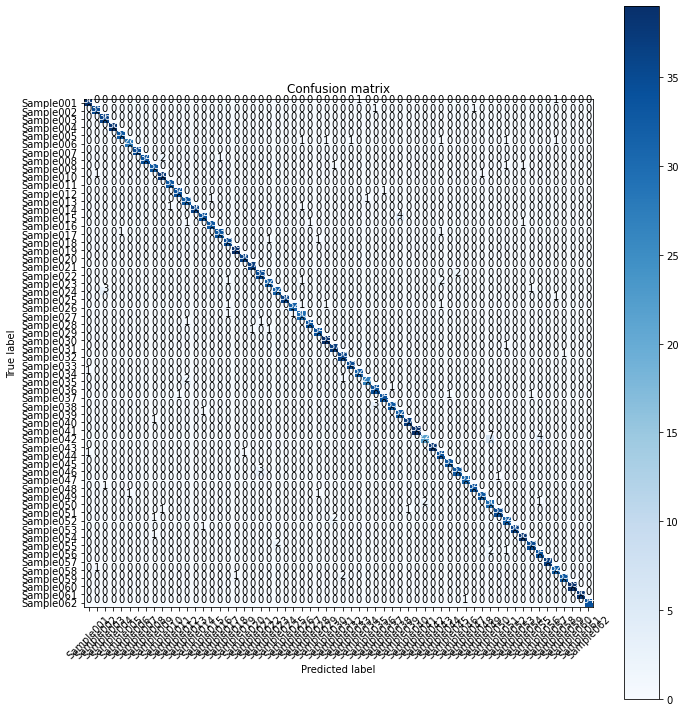

In [ ]:
cm=conf(model,train_loader,62)
cm=cm.cpu().numpy().astype('uint64')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)

# Experiment 2- Mobilenet V2 with small image size(28x28)

dataset with small images

In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=False,transforms=seq_s)


batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


2480


Model, Loss and Other Auxilary Training Initilisations

In [ ]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=False)
model.classifier= nn.Sequential(
     nn.Dropout(p=0.2, inplace=False)
    ,nn.Linear(in_features=1280, out_features=62, bias=True))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
model=model.to(device)

init_weights(model,'kaiming')
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
con=Convergence()
meters={'val_loss':AverageValueMeter(),'val_a1':AverageValueMeter(),'val_a3':AverageValueMeter(),'val_a5':AverageValueMeter(),'train_loss':AverageValueMeter(),'time':SumMeter()}

initialize network with kaiming


RUN

In [ ]:
run(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_part3_pre2',0,100,10)

 Epoch: 0 Iter: 0 Average train loss: 4.6927
 Epoch: 0 Iter: 0 Average val loss: 4.2801 Acc1: 0.00 Acc3: 0.00 Acc5: 0.00


====> After epoch 0 
====>Epoch Time: 0m 35s
====>Average train loss: 4.6406 
====> Average val loss: 4.3335 Acc1: 0.03 Acc3: 0.05 Acc5: 0.09


 Epoch: 1 Iter: 0 Average train loss: 4.3505
 Epoch: 1 Iter: 0 Average val loss: 4.2661 Acc1: 0.00 Acc3: 0.00 Acc5: 0.00


====> After epoch 1 
====>Epoch Time: 0m 35s
====>Average train loss: 4.5197 
====> Average val loss: 4.2436 Acc1: 0.02 Acc3: 0.06 Acc5: 0.11


 Epoch: 2 Iter: 0 Average train loss: 4.5376
 Epoch: 2 Iter: 0 Average val loss: 4.2707 Acc1: 0.00 Acc3: 0.12 Acc5: 0.12


====> After epoch 2 
====>Epoch Time: 0m 34s
====>Average train loss: 4.4813 
====> Average val loss: 4.2955 Acc1: 0.01 Acc3: 0.06 Acc5: 0.11


 Epoch: 3 Iter: 0 Average train loss: 4.0189
 Epoch: 3 Iter: 0 Average val loss: 4.0389 Acc1: 0.00 Acc3: 0.19 Acc5: 0.25


====> After epoch 3 
====>Epoch Time: 0m 34s
====>Average train loss: 4.4034

Evaluation

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 17 
====>conv Time: 624.2536418437958
====>Average train loss: 4.1421 +-0.0377


In [ ]:
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
acc_meter=AverageValueMeter()
model.eval()
for batch_idx, (data,label) in enumerate(test_loader):
    data = data.to(device)
    label=label.to(device)
    data = data.expand(-1, 3, -1, -1)
    output= model(data)
    
   
    r=accuracy_fn(output.data,label.data,(1,3,5))
    acc_meter.add(r[0].item())
print('Test_accuracy:{}'.format(acc_meter.value()))

Test_accuracy:0.0390625


In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

In [ ]:
lst1=os.listdir('/content/train')
lst1.sort()

print(lst1)

['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']


Confusion matrix, without normalization
[[3 2 1 ... 1 0 0]
 [3 1 1 ... 1 0 0]
 [1 0 2 ... 1 0 0]
 ...
 [0 1 0 ... 0 1 0]
 [0 0 3 ... 0 2 0]
 [2 0 4 ... 0 0 1]]


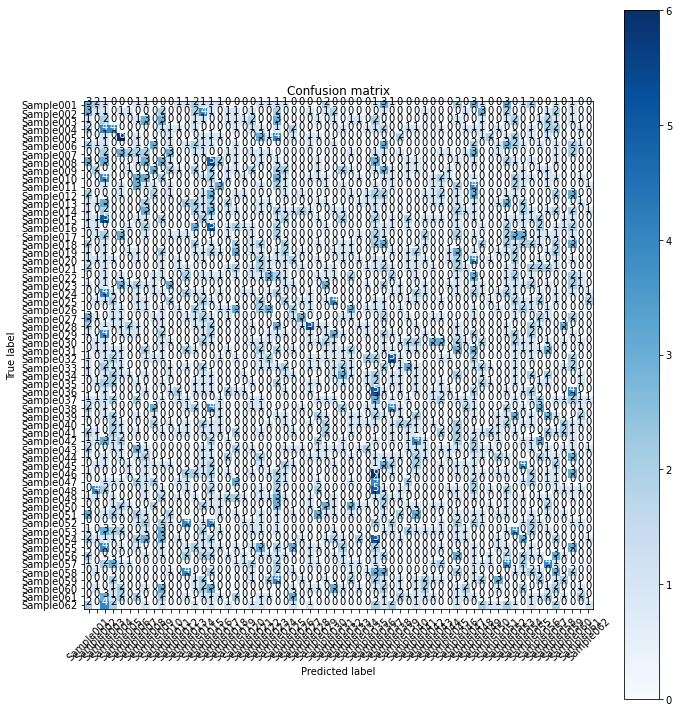

In [ ]:
cm=conf(model,train_loader,62)
cm=cm.cpu().numpy().astype('uint64')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)

# Experiment 3- Homegenous capsule based model with small image size(28x28)

Model based from the paper 'A Branching and Merging Convolutional Network with Homogeneous Filter Capsules’

In [ ]:
class conv(nn.Module):
  def __init__(self, in_fea,out_fea):
    super().__init__()
    self.layer=nn.Sequential(nn.Conv2d(in_fea,out_fea,3),
                             nn.Conv2d(out_fea,out_fea,3),
                             nn.Conv2d(out_fea,out_fea,3))
  def forward(self,x):
    return self.layer(x)

class capsule(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.in_fea=in_fea
      self.layer1=nn.Linear(in_fea,out_fea)
      self.layer2=nn.Sequential(nn.Dropout(0.2),nn.BatchNorm1d(out_fea),nn.ReLU())   
    def forward(self,x):
       x=x.view(-1,self.in_fea,x.shape[2]*x.shape[3])
       x=x.permute(0,2,1)
       x=self.layer1(x)
       x=torch.sum(x,dim=1)
       x=self.layer2(x)
       return x
class BMCNN(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.block1=conv(in_fea,64)
      self.block2=conv(64,112)
      self.block3=conv(112,160)
      self.cap1=capsule(64,out_fea)
      self.cap2=capsule(112,out_fea)
      self.cap3=capsule(160,out_fea)
    def forward(self,x):
       x1=self.block1(x)
       x2=self.block2(x1)
       x3=self.block3(x2)
       x1=self.cap1(x1)
       x2=self.cap2(x2)
       x3=self.cap3(x3)
       x=x1+x2+x3
       return x 

      


dataset with small images

In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=False,transforms=seq_s)


batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


2480


Model, Loss and Other Auxilary Training Initilisations

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

model=BMCNN(3,62)
model=model.to(device)
init_weights(model,'kaiming')
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
con=Convergence()
meters={'val_loss':AverageValueMeter(),'val_a1':AverageValueMeter(),'val_a3':AverageValueMeter(),'val_a5':AverageValueMeter(),'train_loss':AverageValueMeter(),'time':SumMeter()}

initialize network with kaiming


RUN

In [ ]:
run(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_part3_pre2',0,100,10)

 Epoch: 0 Iter: 0 Average train loss: 4.5089
 Epoch: 0 Iter: 0 Average val loss: 4.6461 Acc1: 0.00 Acc3: 0.00 Acc5: 0.06


====> After epoch 0 
====>Epoch Time: 0m 32s
====>Average train loss: 4.4948 
====> Average val loss: 4.7613 Acc1: 0.00 Acc3: 0.03 Acc5: 0.07


 Epoch: 1 Iter: 0 Average train loss: 4.6987
 Epoch: 1 Iter: 0 Average val loss: 4.4952 Acc1: 0.00 Acc3: 0.00 Acc5: 0.06


====> After epoch 1 
====>Epoch Time: 0m 32s
====>Average train loss: 4.4694 
====> Average val loss: 4.3415 Acc1: 0.01 Acc3: 0.07 Acc5: 0.09


 Epoch: 2 Iter: 0 Average train loss: 4.3883
 Epoch: 2 Iter: 0 Average val loss: 3.9406 Acc1: 0.12 Acc3: 0.19 Acc5: 0.19


====> After epoch 2 
====>Epoch Time: 0m 32s
====>Average train loss: 4.3267 
====> Average val loss: 4.1365 Acc1: 0.03 Acc3: 0.09 Acc5: 0.14


 Epoch: 3 Iter: 0 Average train loss: 4.1156
 Epoch: 3 Iter: 0 Average val loss: 3.9596 Acc1: 0.00 Acc3: 0.06 Acc5: 0.25


====> After epoch 3 
====>Epoch Time: 0m 32s
====>Average train loss: 4.2695

Evaluation

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 21 
====>conv Time: 702.635479927063
====>Average train loss: 3.3322 +-0.0179


In [ ]:
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
acc_meter=AverageValueMeter()
model.eval()
for batch_idx, (data,label) in enumerate(test_loader):
    data = data.to(device)
    label=label.to(device)
    data = data.expand(-1, 3, -1, -1)
    output= model(data)
    
   
    r=accuracy_fn(output.data,label.data,(1,3,5))
    acc_meter.add(r[0].item())
print('Test_accuracy:{}'.format(acc_meter.value()))

Test_accuracy:0.19140625000000003


In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

In [ ]:
lst1=os.listdir('/content/train')
lst1.sort()

print(lst1)

['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']


Confusion matrix, without normalization
[[ 0  3  0 ...  1  0  0]
 [ 0  6  2 ...  2  0  0]
 [ 0  0  3 ...  0  1  0]
 ...
 [ 0  0  0 ... 12  1  0]
 [ 0  0  0 ...  1  7  0]
 [ 0  0  1 ...  0  1 12]]


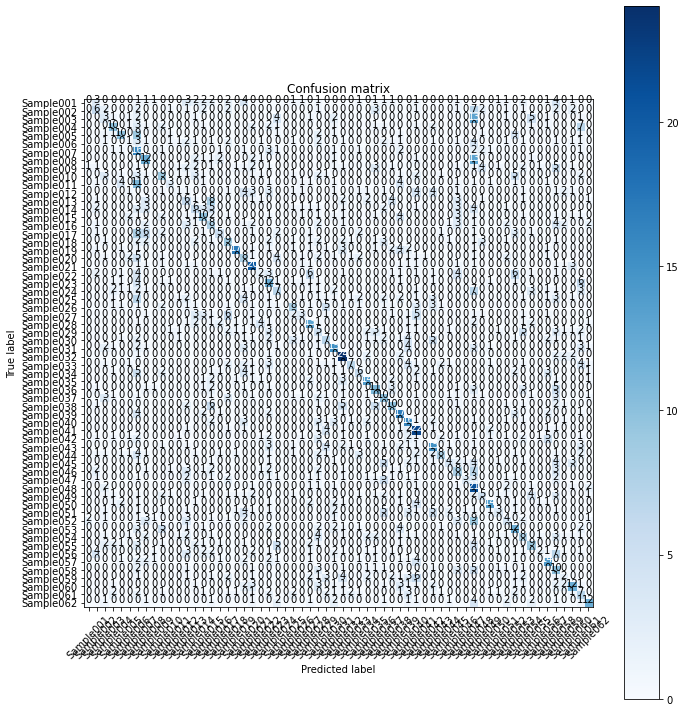

In [ ]:
cm=conf(model,train_loader,62)
cm=cm.cpu().numpy().astype('uint64')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)

# Experiment 4- Homegenous capsule based model with added relu and Dropout for small image size(28x28)

Model based from the paper 'A Branching and Merging Convolutional Network with Homogeneous Filter Capsules’

In [ ]:
class conv(nn.Module):
  def __init__(self, in_fea,out_fea):
    super().__init__()
    self.layer=nn.Sequential(nn.Conv2d(in_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2),
                             nn.Conv2d(out_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2),
                             nn.Conv2d(out_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2))
  def forward(self,x):
    return self.layer(x)

class capsule(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.in_fea=in_fea
      self.layer1=nn.Linear(in_fea,out_fea)
      self.layer2=nn.Sequential(nn.Dropout(0.2),nn.BatchNorm1d(out_fea),nn.ReLU())   
    def forward(self,x):
       x=x.view(-1,self.in_fea,x.shape[2]*x.shape[3])
       x=x.permute(0,2,1)
       x=self.layer1(x)
       x=torch.sum(x,dim=1)
       x=self.layer2(x)
       return x
class BMCNN(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.block1=conv(in_fea,64)
      self.block2=conv(64,112)
      self.block3=conv(112,160)
      self.cap1=capsule(64,out_fea)
      self.cap2=capsule(112,out_fea)
      self.cap3=capsule(160,out_fea)
    def forward(self,x):
       x1=self.block1(x)
       x2=self.block2(x1)
       x3=self.block3(x2)
       x1=self.cap1(x1)
       x2=self.cap2(x2)
       x3=self.cap3(x3)
       x=x1+x2+x3
       return x 

      


dataset with small images

In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=False,transforms=seq_s)


batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


2480


Model, Loss and Other Auxilary Training Initilisations

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

model=BMCNN(3,62)
model=model.to(device)
init_weights(model,'kaiming')
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
con=Convergence()
meters={'val_loss':AverageValueMeter(),'val_a1':AverageValueMeter(),'val_a3':AverageValueMeter(),'val_a5':AverageValueMeter(),'train_loss':AverageValueMeter(),'time':SumMeter()}

initialize network with kaiming


RUN

In [ ]:
run(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_part3_pre2',0,100,10)

 Epoch: 0 Iter: 0 Average train loss: 5.2786
 Epoch: 0 Iter: 0 Average val loss: 4.5812 Acc1: 0.00 Acc3: 0.00 Acc5: 0.06


====> After epoch 0 
====>Epoch Time: 0m 31s
====>Average train loss: 4.6054 
====> Average val loss: 4.5204 Acc1: 0.03 Acc3: 0.06 Acc5: 0.07


 Epoch: 1 Iter: 0 Average train loss: 4.5097
 Epoch: 1 Iter: 0 Average val loss: 4.3433 Acc1: 0.00 Acc3: 0.06 Acc5: 0.06


====> After epoch 1 
====>Epoch Time: 0m 31s
====>Average train loss: 4.5217 
====> Average val loss: 4.2564 Acc1: 0.01 Acc3: 0.04 Acc5: 0.07


 Epoch: 2 Iter: 0 Average train loss: 4.7933
 Epoch: 2 Iter: 0 Average val loss: 3.9823 Acc1: 0.06 Acc3: 0.12 Acc5: 0.19


====> After epoch 2 
====>Epoch Time: 0m 31s
====>Average train loss: 4.3722 
====> Average val loss: 4.1706 Acc1: 0.01 Acc3: 0.07 Acc5: 0.11


 Epoch: 3 Iter: 0 Average train loss: 4.4566
 Epoch: 3 Iter: 0 Average val loss: 4.3689 Acc1: 0.00 Acc3: 0.00 Acc5: 0.06


====> After epoch 3 
====>Epoch Time: 0m 31s
====>Average train loss: 4.2660

Evaluation

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 36 
====>conv Time: 1180.346841096878
====>Average train loss: 1.1662 +-0.0331


In [ ]:
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
acc_meter=AverageValueMeter()
model.eval()
for batch_idx, (data,label) in enumerate(test_loader):
    data = data.to(device)
    label=label.to(device)
    data = data.expand(-1, 3, -1, -1)
    output= model(data)
    
   
    r=accuracy_fn(output.data,label.data,(1,3,5))
    acc_meter.add(r[0].item())
print('Test_accuracy:{}'.format(acc_meter.value()))

Test_accuracy:0.6640625


In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

In [ ]:
lst1=os.listdir('/content/train')
lst1.sort()

print(lst1)

['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']


Confusion matrix, without normalization
[[29  0  0 ...  0  0  0]
 [ 1 25  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 38  0  0]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 32]]


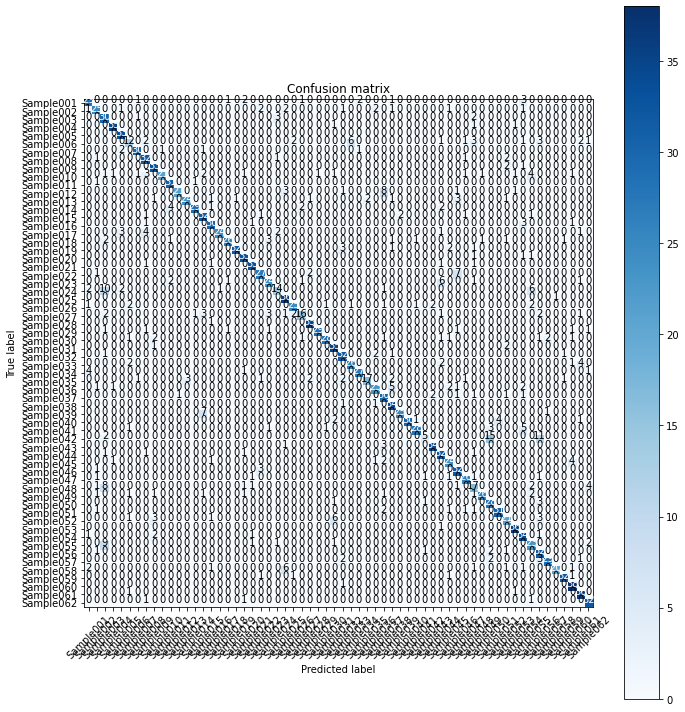

In [ ]:
cm=conf(model,train_loader,62)
cm=cm.cpu().numpy().astype('uint64')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)